# Obtain

The data for all our Models was taken from the Kaggle competition whose URL is listed here:

https://www.kaggle.com/c/mens-march-mania-2022/data

This URL contains 20 CSVs of men's NCAA basketball data, but our code only uses eight of them:

MTeams: Contains teams current name and assigned TeamID, as well as number of years in the first division.

MNCAATourneySeeds: Identifies the seed for each team in every tournament in the data set.

MRegularSeasonCompactResults and MRegularSeasonDetailedResults: Contains general and detailed statistics for every game in the regular season (data goes back to 1985 for compact and back to 2003 for detailed). While compact results only contains points scored, detailed results contains statistics such as assists, rebounds, and fouls by both the winning and losing team.

MTourneyCompactResults and MTourneyDetailedResults: Contains the same statistics as the Regular Season CSVs but for the tournament games. 

MSampleSubmissionStage2: This file contains a Sample submission for the Kaggle competition. For the purposes of this project, we will be using this template to help structure our own results.

MMasseyOrdinals_thruDay128: Provides the ranking of teams through multiple ranking methodologies. More information can be found here: (https://masseyratings.com/cb/compare.htm). It goes till day 128 because that was the most recent data provided by Kaggle.

Keep in mind that these are just summaries of what these files contain. For information on what these files contain and the competition itself, please consult the URL linked above.

In [98]:
#https://www.kaggle.com/c/mens-march-mania-2022/data
#

In [99]:
# General Modules
import pandas as pd
import numpy as np

# Modules used in the Gradient Boost Model
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier

# Modules used in the Neural Network Model
from tensorflow import keras
from keras import layers
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils

# Tracks the run time of each model
import time

# Modules for visualizations
import matplotlib.pyplot as plt
%matplotlib inline

In [100]:
# CSV files taken from Kaggle
tcr_df = pd.read_csv('MNCAATourneyCompactResults.csv')
# ts_df = pd.read_csv('MNCAATourneySeeds.csv')
rscr_df = pd.read_csv('MRegularSeasonCompactResults.csv')
ss_df = pd.read_csv('MSampleSubmissionStage2.csv')
massey_df = pd.read_csv('MMasseyOrdinals_thruDay128.csv')
tbs_df = pd.read_csv('MNCAATourneyDetailedResults.csv')
rsbs_df = pd.read_csv('MRegularSeasonDetailedResults.csv') 
teams_df = pd.read_csv('MTeams.csv')

# Scrub

Due to the size and scope of the data provided, the following website was used to helped with data scrubbing:

https://www.activestate.com/blog/fantasy-march-madness-how-to-predict-winners/


In [101]:
# This function calculates the average points per game (PPG) of each team
# This function takes the Regular Season Compact Results as the input
def get_ppg(rscr_df):
    # Gametime normalization (accounts for overtime)
    rscr_df['GameDuration'] = rscr_df['NumOT']
    for i in range(len(rscr_df.NumOT.value_counts())):
        rscr_df.loc[rscr_df['NumOT'] == rscr_df.NumOT.value_counts().index[i], 'GameDuration'] = 40 + i*5
    rscr_df['Wppg'] = (rscr_df['WScore'] / rscr_df['GameDuration']) * 40
    rscr_df['Lppg'] = (rscr_df['LScore'] / rscr_df['GameDuration']) * 40
    # Drop unnecesary columns 
    rscr_df = rscr_df.drop(['DayNum', 'WLoc', 'NumOT', 'WScore','LScore','GameDuration'], axis = 1)
    # Calculate average points per game and number of games for winning and losing team
    Wppg_df = rscr_df[["Season","WTeamID",'Wppg']].groupby(["Season","WTeamID"]).agg(['mean', 'count'])
    Lppg_df = rscr_df[["Season","LTeamID",'Lppg']].groupby(["Season","LTeamID"]).agg(['mean', 'count'])
    Wppg_df.columns = Wppg_df.columns.droplevel(0)
    Wppg_df = Wppg_df.reset_index().rename(columns = {'mean':'Wppg', 'count':'WGames'})
    Lppg_df.columns = Lppg_df.columns.droplevel(0)
    Lppg_df = Lppg_df.reset_index().rename(columns = {'mean':'Lppg', 'count':'LGames'})
    # Merge PPG for wins and losses and fill NaNs with 0s for undefeated and no-win teams
    ppg_df = pd.merge(Wppg_df, Lppg_df, left_on=['Season', 'WTeamID'], right_on=['Season', 'LTeamID'], how='outer')
    ppg_df = ppg_df.fillna({'WTeamID': ppg_df.LTeamID, 'Wppg': 0, 'WGames': 0, 'LTeamID': ppg_df.WTeamID , 'Lppg': 0, 'LGames': 0})
    # Calculate PPG and win percentage for season 
    ppg_df['PPG'] = (ppg_df['Wppg']*ppg_df['WGames'] + ppg_df['Lppg']*ppg_df['LGames'])/(ppg_df['WGames'] + ppg_df['LGames'])
    ppg_df['WPerc'] = (ppg_df['WGames'])/(ppg_df['WGames'] + ppg_df['LGames'])
    ppg_df['TeamID'] = ppg_df['WTeamID'].astype('int32')
    ppg_df['GamesPlayed'] = (ppg_df['WGames'] + ppg_df['LGames'])
    ppg_df = ppg_df.drop(['WTeamID', 'Wppg' ,'WGames','LTeamID', 'Lppg','LGames'],axis = 1)
    return ppg_df 


It should be noted that normalizing for overtime games was an important step because it would inflate the metrics of teams that had multiple overtime games. It should also be noted that rows of the input df are game statistics while the rows of the output df are team statistics by season.

After running the function, we are left with the average Points per Game, Win Percentage, and Games Played for each team by season.

In [102]:
# Prints the resulting PPG data frame
ppg_df = get_ppg(rscr_df)
print(ppg_df.tail())

       Season        PPG  WPerc  TeamID  GamesPlayed
12294    2015  51.111111    0.0    1212         27.0
12295    2015  52.265873    0.0    1363         28.0
12296    2021  55.444444    0.0    1152          9.0
12297    2022  60.248889    0.0    1175         25.0
12298    2022  60.888889    0.0    1249         27.0


The next function has a similar goal to that of the get_ppg() function, but it obtains the important metrics from the detailed (rather than the compact) regular season results. All the statistics are summarized in a metric created by original writer of the code (link above) that averages certain statistics over the entire the regular season. The 30-day efficiency, which is the last 30 days of the regular season, accounts for momentum heading into the tournament.

Offensive Efficiency = Points Made + Assists + Offensive Rebounds

Defensive Efficiency = Points Missed (by Opponent) + Steals + Blocks + Defensive Rebounds + Turnovers (by Opponent) - Personal Fouls

In [103]:
# This function takes the Detailed Season Compact Results as the input
def get_efficiency(rsbs_df):
    # Gametime normalization 
    rsbs_df['GameDuration'] = rsbs_df['NumOT']
    for i in range(len(rsbs_df.NumOT.value_counts())):
        rsbs_df.loc[rsbs_df['NumOT'] == rsbs_df.NumOT.value_counts().index[i], 'GameDuration'] = 40 + i*5

    # Normalizing winning team statisitcs
    rsbs_df['WFGM'] = (rsbs_df['WFGM'] / rsbs_df['GameDuration']) * 40
    rsbs_df['WFGA'] = (rsbs_df['WFGA'] / rsbs_df['GameDuration']) * 40
    rsbs_df['WFGM3'] = (rsbs_df['WFGM3'] / rsbs_df['GameDuration']) * 40
    rsbs_df['WFGA3'] = (rsbs_df['WFGA3'] / rsbs_df['GameDuration']) * 40
    rsbs_df['WFTM'] = (rsbs_df['WFTM'] / rsbs_df['GameDuration']) * 40
    rsbs_df['WFTA'] = (rsbs_df['WFTA'] / rsbs_df['GameDuration']) * 40
    rsbs_df['WOR'] = (rsbs_df['WOR'] / rsbs_df['GameDuration']) * 40
    rsbs_df['WDR'] = (rsbs_df['WDR'] / rsbs_df['GameDuration']) * 40
    rsbs_df['WAst'] = (rsbs_df['WAst'] / rsbs_df['GameDuration']) * 40
    rsbs_df['WTO'] = (rsbs_df['WTO'] / rsbs_df['GameDuration']) * 40
    rsbs_df['WStl'] = (rsbs_df['WStl'] / rsbs_df['GameDuration']) * 40
    rsbs_df['WBlk'] = (rsbs_df['WBlk'] / rsbs_df['GameDuration']) * 40
    rsbs_df['WPF'] = (rsbs_df['WPF'] / rsbs_df['GameDuration']) * 40
    # Normalizing losing Team statitics
    rsbs_df['LFGM'] = (rsbs_df['LFGM'] / rsbs_df['GameDuration']) * 40
    rsbs_df['LFGA'] = (rsbs_df['LFGA'] / rsbs_df['GameDuration']) * 40
    rsbs_df['LFGM3'] = (rsbs_df['LFGM3'] / rsbs_df['GameDuration']) * 40
    rsbs_df['LFGA3'] = (rsbs_df['LFGA3'] / rsbs_df['GameDuration']) * 40
    rsbs_df['LFTM'] = (rsbs_df['LFTM'] / rsbs_df['GameDuration']) * 40
    rsbs_df['LFTA'] = (rsbs_df['LFTA'] / rsbs_df['GameDuration']) * 40
    rsbs_df['LOR'] = (rsbs_df['LOR'] / rsbs_df['GameDuration']) * 40
    rsbs_df['LDR'] = (rsbs_df['LDR'] / rsbs_df['GameDuration']) * 40
    rsbs_df['LAst'] = (rsbs_df['LAst'] / rsbs_df['GameDuration']) * 40
    rsbs_df['LTO'] = (rsbs_df['LTO'] / rsbs_df['GameDuration']) * 40
    rsbs_df['LStl'] = (rsbs_df['LStl'] / rsbs_df['GameDuration']) * 40
    rsbs_df['LBlk'] = (rsbs_df['LBlk'] / rsbs_df['GameDuration']) * 40
    rsbs_df['LPF'] = (rsbs_df['LPF'] / rsbs_df['GameDuration']) * 40
    # Calculate total points made and missed per game 
    rsbs_df['wPointsMade'] = (2* (rsbs_df['WFGM'] - rsbs_df['WFGM3'])) + 3*rsbs_df['WFGM3'] + rsbs_df['WFTM']
    rsbs_df['wPointsMissed'] = (2* (rsbs_df['WFGA'] - rsbs_df['WFGA3'])) + 3*rsbs_df['WFGA3'] + rsbs_df['WFTA'] - rsbs_df['wPointsMade']
    rsbs_df['lPointsMade'] = (2* (rsbs_df['LFGM'] - rsbs_df['LFGM3'])) + 3*rsbs_df['LFGM3'] + rsbs_df['LFTM']
    rsbs_df['lPointsMissed'] = (2* (rsbs_df['LFGA'] - rsbs_df['LFGA3'])) + 3*rsbs_df['LFGA3'] + rsbs_df['LFTA'] - rsbs_df['lPointsMade']
    # Calculate offensive and defensive efficiency metrics for winning and losing team 
    rsbs_df['WoEFF'] = rsbs_df['wPointsMade'] +  rsbs_df['WAst'] + rsbs_df['WOR']
    rsbs_df['WdEFF'] = rsbs_df['lPointsMissed'] + rsbs_df['WStl'] + rsbs_df['WBlk'] + rsbs_df['WDR'] + rsbs_df['LTO'] - rsbs_df['WPF']
    rsbs_df['LoEFF'] = rsbs_df['lPointsMade'] +  rsbs_df['LAst'] + rsbs_df['LOR']
    rsbs_df['LdEFF'] = rsbs_df['wPointsMissed'] + rsbs_df['LStl'] + rsbs_df['LBlk'] + rsbs_df['LDR'] + rsbs_df['WTO'] - rsbs_df['LPF']
    # Extract relevant columns and rename 
    Weff_df = rsbs_df[['Season', 'DayNum', 'WTeamID','WoEFF', 'WdEFF']]
    Weff_df = Weff_df.rename(columns = {'WTeamID': 'TeamID','WoEFF': 'oEFF', 'WdEFF': 'dEFF'})
    Leff_df = rsbs_df[['Season', 'DayNum', 'LTeamID','LoEFF', 'LdEFF']]
    Leff_df = Leff_df.rename(columns = {'LTeamID': 'TeamID','LoEFF': 'oEFF', 'LdEFF': 'dEFF'})
    eff_df = pd.concat([Weff_df, Leff_df]) 
    # Take seasonal and 30 day averages of the efficiency metrics
    effseas_df = eff_df.groupby(by = ['Season', 'TeamID']).agg('mean').reset_index().drop(['DayNum'], axis = 1)
    # eff30day_df = eff_df[eff_df.DayNum >= 100].groupby(by = ['Season', 'TeamID']).agg('mean').reset_index().drop(['DayNum'], axis = 1)
    eff30day_df = eff_df[eff_df.DayNum >= 98].groupby(by = ['Season', 'TeamID']).agg('mean').reset_index().drop(['DayNum'], axis = 1)
    eff30day_df = eff30day_df.rename(columns = {'oEFF': 'oEFF_30day', 'dEFF': 'dEFF_30day' })
    eff_df = pd.merge(effseas_df,eff30day_df, how = 'outer', on = ['Season', 'TeamID']) 
    return eff_df 

The resulting output consists of the Offensive and Defensive Efficiency (both overall and the over the last 30 days in the data) by team for every season going back to 2003.

Future Improvement Opportunity: Identify all tournament champions from 2003-2022 and see where they stack up efficiency-wise compared to their competition. 

In [104]:
# Prints the resulting efficiency data frame
eff_df = get_efficiency(rsbs_df)
print(eff_df.head())

   Season  TeamID        oEFF        dEFF  oEFF_30day  dEFF_30day
0    2003    1102   74.428571   78.321429   71.500000   66.625000
1    2003    1103  100.188477   97.734156   93.666667   99.472222
2    2003    1104   94.599206  112.023810   96.750000  109.125000
3    2003    1105   97.922222  114.037607  106.358025  114.888889
4    2003    1106   87.134921  111.956349   84.333333  108.555556


This function seeks the summarize the Massey Ordinals data. Since there are various ranking metrics within this dataset, we will be finding the mean and median of all of them for the last day available (Day 128). We will also be using the Massey rank as its own column because it is the most accurate.

In [105]:
# This function takes in the Massey Ordinals as the input
def get_rank(massey_df):
  # Gets the data from the last day available
    rankings_df = massey_df[massey_df['RankingDayNum'] == 128]
    rankings_df = rankings_df.reset_index().drop(['index','RankingDayNum'], axis = 1)
    # Finds the median of all the rankings
    median_df = rankings_df.groupby(by = ['Season','TeamID'])[['OrdinalRank']].median().reset_index()
    median_df = median_df.rename(columns = {'OrdinalRank':'MedianRank'})
    # Finds the mean of all the rankings
    mean_df = rankings_df.groupby(by = ['Season','TeamID'])[['OrdinalRank']].mean().reset_index()
    mean_df = mean_df.rename(columns = {'OrdinalRank':'MeanRank'})
    # Isolates the Massey ranking as its own column
    massey_df = rankings_df[rankings_df['SystemName'] == 'MAS']
    massey_df = massey_df.reset_index().drop(['index','SystemName'], axis = 1)
    massey_df = massey_df.rename(columns = {'OrdinalRank':'MasseyRank'})
    # Merges the data into one data frame
    rankings_df = pd.merge(median_df, massey_df, left_on=['Season', 'TeamID'], right_on=['Season', 'TeamID'], how='left')
    rankings_df = pd.merge(rankings_df, mean_df, left_on=['Season', 'TeamID'], right_on=['Season', 'TeamID'], how='left')
    return rankings_df 

In [106]:
# Prints the resulting rankings data frame
rankings_df = get_rank(massey_df)
print(rankings_df.tail())

      Season  TeamID  MedianRank  MasseyRank    MeanRank
6886    2022    1468       191.0       187.0  188.315789
6887    2022    1469       274.0       277.0  268.245614
6888    2022    1470       225.0       240.0  225.052632
6889    2022    1471       263.0       263.0  262.368421
6890    2022    1472       315.0       320.0  311.392857


This function will help us get our results into the correct format, and (in so doing) create the testing data. The data consists of five columns:

ID (Season_TeamID(lower)_TeamID(higher))

Season

TeamID_1

TeamID_2

Result

In [107]:
'''
This data frame takes the Sample Submission and Tournament Compact Results as
the input.
'''
def prep_submission(ss_df,tcr_df):
    features_df = ss_df.copy()
    # extract season and team IDs
    features_df['Season'] = features_df['ID'].map(lambda x: int(x[:4]))
    features_df['WTeamID'] = features_df['ID'].map(lambda x: int(x[5:9]))
    features_df['LTeamID'] = features_df['ID'].map(lambda x: int(x[10:14]))
    features_df = features_df.rename(columns= {'WTeamID':'TeamID_1','LTeamID':'TeamID_2'})
    # Extract seasons starting from 2016 and create Result column corresponding to winner and loser
    Wtcr_df = tcr_df[tcr_df.Season >= 2016].loc[:,['Season', 'WTeamID', 'LTeamID']].reset_index().drop('index', axis = 1)
    Wtcr_df = Wtcr_df.rename(columns = {'WTeamID': 'TeamID_1', 'LTeamID': 'TeamID_2'})
    Wtcr_df['Result'] = 1
    Ltcr_df = tcr_df[tcr_df.Season >= 2016].loc[:,['Season', 'WTeamID', 'LTeamID']].reset_index().drop('index', axis = 1)
    Ltcr_df = Ltcr_df.rename(columns = {'WTeamID': 'TeamID_2', 'LTeamID': 'TeamID_1'})
    Ltcr_df['Result'] = 0
    tcr_df = pd.concat([Wtcr_df,Ltcr_df], sort=False).reset_index().drop('index', axis = 1)
    tcr_df['ID'] = tcr_df['Season'].apply(str) + '_' + tcr_df['TeamID_1'].apply(str) + '_' + tcr_df['TeamID_2'].apply(str)
    tcr_df = tcr_df.drop(['Season', 'TeamID_1', 'TeamID_2'],axis = 1)
    # merge results onto sample submission
    features_df = pd.merge(features_df,tcr_df, how = 'left', on = 'ID')
    features_df = features_df.drop(['Pred'],axis = 1)
    return features_df 

The Results column is blank because this code generates all possible matchups between teams (not just the ones that happened). These rows will be removed later.

In [108]:
# Prints the resulting submission data frame
features_df = prep_submission(ss_df,tcr_df)
print(features_df.head())

               ID  Season  TeamID_1  TeamID_2  Result
0  2022_1103_1104    2022      1103      1104     NaN
1  2022_1103_1112    2022      1103      1112     NaN
2  2022_1103_1116    2022      1103      1116     NaN
3  2022_1103_1120    2022      1103      1120     NaN
4  2022_1103_1124    2022      1103      1124     NaN


This function has a similar output to the prep_submission function but it uses the regular season compact results to create the training data. We will be using the 2016-2021 data as a they are the most recent complete seasons (2020 will be excluded).

In [109]:
def prep_regseason(rscr_df):  
    # Extract seasons starting from 2016 and create Result column corresponding to winner and loser
    Wrscr_df = rscr_df[rscr_df.Season >= 2016].loc[:,['Season', 'WTeamID', 'LTeamID']].reset_index().drop('index', axis = 1)
    Wrscr_df = Wrscr_df.rename(columns = {'WTeamID': 'TeamID_1', 'LTeamID': 'TeamID_2'})
    Wrscr_df['Result'] = 1
    Lrscr_df = rscr_df[rscr_df.Season >= 2016].loc[:,['Season', 'WTeamID', 'LTeamID']].reset_index().drop('index', axis = 1)
    Lrscr_df = Lrscr_df.rename(columns = {'WTeamID': 'TeamID_2', 'LTeamID': 'TeamID_1'})
    Lrscr_df['Result'] = 0
    rscr_df = pd.concat([Wrscr_df,Lrscr_df], sort=False).reset_index().drop('index', axis = 1)
    rscr_df['ID'] = rscr_df['Season'].apply(str) + '_' + rscr_df['TeamID_1'].apply(str) + '_' + rscr_df['TeamID_2'].apply(str)
    return rscr_df 

In [110]:
# Prints the resulting regular season (training) data frame
rscr_df = prep_regseason(rscr_df)
print(rscr_df.head())

   Season  TeamID_1  TeamID_2  Result              ID
0    2016      1104      1244       1  2016_1104_1244
1    2016      1105      1408       1  2016_1105_1408
2    2016      1112      1334       1  2016_1112_1334
3    2016      1115      1370       1  2016_1115_1370
4    2016      1116      1380       1  2016_1116_1380


This function serves to put everything together. It takes in a features_df (which can be either the train or test data frame) and finds the corresponding statistics given the teams and season. 

In [111]:
def merge_features(features_df, ppg_df,eff_df,rankings_df):
    # Finds the PPG metrics for each row in the features_df
    Wppg_df = ppg_df.rename(columns = {'PPG':'PPG_1','WPerc':'WPerc_1'})
    Lppg_df = ppg_df.rename(columns = {'PPG':'PPG_2','WPerc':'WPerc_2'})
    Wfeatures_df = pd.merge(features_df, Wppg_df,left_on=['Season', 'TeamID_1'], right_on=['Season', 'TeamID'], how='left')
    Wfeatures_df = Wfeatures_df.drop(['TeamID', 'GamesPlayed'], axis = 1)
    features_df = pd.merge(Wfeatures_df, Lppg_df,left_on=['Season', 'TeamID_2'], right_on=['Season', 'TeamID'], how='left')
    features_df = features_df.drop(['TeamID', 'GamesPlayed'], axis = 1)

    # Finds the efficiency metrics for each row in the features_df
    Weff_df = eff_df.rename(columns = {'oEFF': 'oEFF_1', 'dEFF': 'dEFF_1','oEFF_30day': 'oEFF_30day_1', 'dEFF_30day': 'dEFF_30day_1'})
    Leff_df = eff_df.rename(columns = {'oEFF': 'oEFF_2', 'dEFF': 'dEFF_2','oEFF_30day': 'oEFF_30day_2', 'dEFF_30day': 'dEFF_30day_2'})
    features_df = pd.merge(features_df, Weff_df, how = 'left', left_on = ['Season', 'TeamID_1'], right_on = ['Season', 'TeamID'])
    features_df = features_df.drop(['TeamID'], axis = 1)
    features_df = pd.merge(features_df, Leff_df, how = 'left', left_on = ['Season', 'TeamID_2'], right_on = ['Season', 'TeamID'])
    features_df = features_df.drop(['TeamID'], axis = 1)
    features_df['PPG_diff'] = features_df['PPG_1'] - features_df['PPG_2']
    features_df['WPerc_diff'] = features_df['WPerc_1'] - features_df['WPerc_2']
    features_df['oEFF_diff'] = features_df['oEFF_1'] - features_df['oEFF_2']
    features_df['dEFF_diff'] = features_df['dEFF_1'] - features_df['dEFF_2']
    features_df['oEFF_30day_diff'] = features_df['oEFF_30day_1'] - features_df['oEFF_30day_2']
    features_df['dEFF_30day_diff'] = features_df['dEFF_30day_1'] - features_df['dEFF_30day_2']
    features_df = features_df.drop(['PPG_1', 'WPerc_1', 'PPG_2', 'WPerc_2', 'oEFF_1', 'dEFF_1', 'oEFF_30day_1', 
                                    'dEFF_30day_1', 'oEFF_2', 'dEFF_2', 'oEFF_30day_2', 'dEFF_30day_2'], axis = 1)
    
    # Finds the rankings metrics for each row in the features_df
    Wrankings_df = rankings_df.rename(columns = {'MedianRank': 'MedianRank_1', 'MasseyRank': 'MasseyRank_1', 'MeanRank' : 'MeanRank_1'})
    Lrankings_df = rankings_df.rename(columns = {'MedianRank': 'MedianRank_2', 'MasseyRank': 'MasseyRank_2', 'MeanRank' : 'MeanRank_2'})
    features_df = pd.merge(features_df,Wrankings_df, how = 'left', left_on = ['Season', 'TeamID_1'], right_on = ['Season', 'TeamID'])
    features_df = features_df.drop(['TeamID'],axis = 1)
    features_df = pd.merge(features_df,Lrankings_df, how = 'left', left_on = ['Season', 'TeamID_2'], right_on = ['Season', 'TeamID'])
    features_df = features_df.drop(['TeamID'],axis = 1)
    features_df['MedianRank_diff'] = features_df['MedianRank_1'] - features_df['MedianRank_2']
    features_df['MasseyRank_diff'] = features_df['MasseyRank_1'] - features_df['MasseyRank_2']
    features_df['MeanRank_diff'] = features_df['MeanRank_1'] - features_df['MeanRank_2']
    features_df = features_df.drop(['MedianRank_1', 'MasseyRank_1', 'MeanRank_1',
                                    'MedianRank_2', 'MasseyRank_2', 'MeanRank_2'], axis = 1)
    return features_df 

This code also calculates the difference of these metrics between the two teams, which is what is put into the final data frames.

What we are left with is a training set made from the regular season statistics and a test set made from the tournament statistics. 

In [112]:
# Prepare regular season df for 2016-2021, i.e. training set
# Will exclude 2020
regseason_df = merge_features(rscr_df, ppg_df,eff_df,rankings_df)

print(regseason_df.head())

   Season  TeamID_1  TeamID_2  Result              ID   PPG_diff  WPerc_diff  \
0    2016      1104      1244       1  2016_1104_1244  -4.593151    0.252155   
1    2016      1105      1408       1  2016_1105_1408   1.914417    0.004202   
2    2016      1112      1334       1  2016_1112_1334  12.351696    0.526807   
3    2016      1115      1370       1  2016_1115_1370  -7.502165   -0.186147   
4    2016      1116      1380       1  2016_1116_1380   5.593638   -0.112903   

   oEFF_diff  dEFF_diff  oEFF_30day_diff  dEFF_30day_diff  MedianRank_diff  \
0  -6.623324   7.875000       -20.033333        -0.766667           -186.0   
1   2.949474  -8.871891        -0.353535        -8.774747            100.0   
2  16.173349  18.008521        17.944444        25.981481           -233.0   
3 -11.832251 -14.376383        -3.232804        -4.906526             67.0   
4  12.630600  -3.121080        -0.050505       -10.040404           -152.0   

   MasseyRank_diff  MeanRank_diff  
0           -1

In [113]:
# Prepare tournament submission df for 2016-2021, i.e. test set. 
# Will exclude 2020
tournament_df = merge_features(features_df, ppg_df,eff_df,rankings_df)

print(tournament_df.head())

               ID  Season  TeamID_1  TeamID_2  Result   PPG_diff  WPerc_diff  \
0  2022_1103_1104    2022      1103      1104     NaN -10.615367    0.115927   
1  2022_1103_1112    2022      1103      1112     NaN -15.204828   -0.202087   
2  2022_1103_1116    2022      1103      1116     NaN  -7.328120   -0.047898   
3  2022_1103_1120    2022      1103      1120     NaN  -8.406340   -0.134073   
4  2022_1103_1124    2022      1103      1124     NaN  -7.184812   -0.102823   

   oEFF_diff  dEFF_diff  oEFF_30day_diff  dEFF_30day_diff  MedianRank_diff  \
0 -17.466846 -15.528002       -15.987654       -10.861111            112.0   
1 -26.161290 -30.072528       -23.635328       -22.413818            134.0   
2 -11.656240 -17.050940        -4.770370       -18.768519            119.0   
3 -13.523096 -23.807863        -8.543210       -24.589506            131.0   
4 -14.616151 -10.753696        -6.296296       -12.441358            133.0   

   MasseyRank_diff  MeanRank_diff  
0            1

As we said earlier, we will only be considering 2016-2021 (excluding 2020). We will isolate those seasons here.

In [114]:
# Note: not all matchups have Results, as we predict all possible matchups for 
# the 5 seasons when only around 335 games actually occur

# Drop matchups that don’t occur, as we cannot evaluate them
regseason_df = regseason_df.dropna()

# Stores regular season statisitcs into dfs by year
regseason_df_2016 = regseason_df[regseason_df.Season == 2016]
regseason_df_2017 = regseason_df[regseason_df.Season == 2017]
regseason_df_2018 = regseason_df[regseason_df.Season == 2018]
regseason_df_2019 = regseason_df[regseason_df.Season == 2019]
regseason_df_2021 = regseason_df[regseason_df.Season == 2021]
# regseason_df_2022 = regseason_df[regseason_df.Season == 2022] 

# Combines the five individual dfs into one giant df
# Uses 2016-2021 (Excluding 2020)
megareg_df = pd.concat([regseason_df_2016, regseason_df_2017, 
regseason_df_2018, regseason_df_2019, regseason_df_2021], ignore_index = True, 
axis = 0)

'''
# Combines the five individual dfs into one giant df
# Uses 2017-2022 (Excluding 2020)
megareg_df = pd.concat([regseason_df_2017, regseason_df_2018, 
regseason_df_2019, regseason_df_2021, regseason_df_2022], ignore_index = True, 
axis = 0)
'''


'\n# Combines the five individual dfs into one giant df\n# Uses 2017-2022 (Excluding 2020)\nmegareg_df = pd.concat([regseason_df_2017, regseason_df_2018, \nregseason_df_2019, regseason_df_2021, regseason_df_2022], ignore_index = True, \naxis = 0)\n'

In [115]:
# Drop matchups that don’t occur, as we cannot evaluate them
tournament_df = tournament_df.dropna()

# Stores tournament statisitcs into dfs by year
tournament_df_2016 = tournament_df[tournament_df.Season == 2016]
tournament_df_2017 = tournament_df[tournament_df.Season == 2017]
tournament_df_2018 = tournament_df[tournament_df.Season == 2018]
tournament_df_2019 = tournament_df[tournament_df.Season == 2019]
tournament_df_2021 = tournament_df[tournament_df.Season == 2021] 

# Combines the five individual dfs into one giant df
megatourney_df = pd.concat([tournament_df_2016, tournament_df_2017, 
tournament_df_2018, tournament_df_2019, tournament_df_2021], 
ignore_index = True, axis = 0)


For both models, the independent variables will be the teams statistics we collected while the dependent variable will be the result of the game.

In [116]:
# Regular season stats and results become the training data
X_train = megareg_df[['PPG_diff', 'WPerc_diff', 'oEFF_diff', 'dEFF_diff', 'oEFF_30day_diff',
                       'dEFF_30day_diff', 'MedianRank_diff', 'MasseyRank_diff', 'MeanRank_diff']]
y_train = megareg_df[['Result']] 

# Tournament stats and results become the test data
X_test = megatourney_df[['PPG_diff', 'WPerc_diff', 'oEFF_diff', 'dEFF_diff', 'oEFF_30day_diff',
                        'dEFF_30day_diff', 'MedianRank_diff', 'MasseyRank_diff', 'MeanRank_diff']]
y_test = megatourney_df[['Result']]  


# Explore

Before we start modeling, we will look at the teams in the tournament, below are the teams in the 2022 tournament, where each row is a matchup.

Below, I have also included the actual matchups for the later stages of the tournament. One of the main issues in predicting matchups in a tournament is that if a matchup in the first round is predicted incorrectly it effects subsequent matchups. In future analysis, I will run the code starting at later stages of the tournament and report the results. 

In [117]:
# Matchups of the first round of the 2022 tournament
r64_matchups = ['Gonzaga', 'Georgia St',
            'Boise St', 'Memphis',
            'Connecticut', 'New Mexico St', 
            'Arkansas', 'Vermont',  
            'Alabama', 'Notre Dame', 
            'Texas Tech', 'Montana St', 
            'Michigan St', 'Davidson', 
            'Duke', 'CS Fullerton', 
            'Baylor', 'Norfolk St', 
            'North Carolina', 'Marquette', 
            'St Mary\'s CA', 'Indiana', 
            'UCLA', 'Akron', 
            'Texas', 'Virginia Tech', 
            'Purdue', 'Yale', 
            'Murray St', 'San Francisco', 
            'Kentucky', 'St Peter\'s',  
            'Arizona', 'Wright St', 
            'Seton Hall', 'TCU', 
            'Houston', 'UAB', 
            'Illinois', 'Chattanooga', 
            'Colorado St', 'Michigan', 
            'Tennessee', 'Longwood', 
            'Ohio St', 'Loyola-Chicago', 
            'Villanova', 'Delaware', 
            'Kansas', 'TX Southern', 
            'San Diego St', 'Creighton', 
            'Iowa', 'Richmond', 
            'Providence', 'S Dakota St', 
            'LSU', 'Iowa St', 
            'Wisconsin', 'Colgate',
            'USC', 'Miami FL',
            'Auburn', 'Jacksonville St']

# Actual Round of 32 matchups
r32_actual = ['Gonzaga', 'Memphis',
            'New Mexico St', 'Arkansas',   
            'Notre Dame', 'Texas Tech',  
            'Michigan St', 'Duke',
            'Baylor', 'North Carolina', 
            'St Mary\'s CA', 'UCLA', 
            'Texas', 'Purdue',
            'Murray St', 'St Peter\'s',  
            'Arizona', 'TCU',
            'Houston', 'Illinois', 
            'Michigan', 'Tennessee', 
            'Ohio St', 'Villanova',
            'Kansas', 'Creighton', 
            'Richmond', 'Providence', 
            'Iowa St', 'Wisconsin', 
            'Miami FL', 'Auburn']

# Actual Sweet 16 matchups
s16_actual = ['Gonzaga', 'Arkansas',   
            'Texas Tech', 'Duke',
            'North Carolina', 'UCLA', 
            'Purdue', 'St Peter\'s',  
            'Arizona', 'Houston',
            'Michigan', 'Villanova',
            'Kansas', 'Providence', 
            'Iowa St', 'Miami FL']

# Actual Elite 8 matchups
e8_actual = ['Arkansas', 'Duke',
            'North Carolina', 'St Peter\'s',  
            'Houston', 'Villanova',
            'Kansas', 'Miami FL']

# Actual Final 4 matchups
f4_actual = ['Duke', 'North Carolina',  
            'Villanova', 'Kansas']

# Actual Championship matchup
champ_actual = ['North Carolina', 'Kansas']

The function below gathers the information for all the teams in the 2022 tournament.

In [118]:
# Takes the teams_df, a input data frame, and a list of teams as the input
def stats2022(teams_df, pjtm_df, teamlist):
  # Finds the teams in the list of matchups
  dff = teams_df[teams_df.TeamName.isin(teamlist)]
  # Subsets the input data frame, including only the teams in the tournament
  dff = pjtm_df[pjtm_df.TeamID.isin(dff.TeamID)]
  # Add the Team Name to the data frame
  dff = pd.merge(teams_df[['TeamName','TeamID']],dff,how = 'right', left_on = ['TeamID'], right_on = ['TeamID'])
  # Uses only data from the 2022 season
  dff = dff[dff.Season == 2022]

  return(dff) 

In [119]:
'''
Finds the PPG, Effieciency, and Ranking data for the teams in the 2022 
tournament.
'''
ppg_stats = stats2022(teams_df, ppg_df, r64_matchups)
eff_stats = stats2022(teams_df, eff_df, r64_matchups)
rank_stats = stats2022(teams_df, rankings_df, r64_matchups)

# ppg_stats = stats2022(teams_df, ppg_df, e8_actual)
# eff_stats = stats2022(teams_df, eff_df, e8_actual)
# rank_stats = stats2022(teams_df, rankings_df, e8_actual)

print(ppg_stats.head())
print(eff_stats.head())
print(rank_stats.head())

      TeamName  TeamID  Season        PPG     WPerc  GamesPlayed
2296     Akron    1103    2022  69.086022  0.709677         31.0
2297   Alabama    1104    2022  79.701389  0.593750         32.0
2298   Arizona    1112    2022  84.290850  0.911765         34.0
2299  Arkansas    1116    2022  76.414141  0.757576         33.0
2300    Auburn    1120    2022  77.492361  0.843750         32.0
      TeamName  TeamID  Season        oEFF        dEFF  oEFF_30day  dEFF_30day
1210     Akron    1103    2022   88.394265  105.326165   88.518519  104.509259
1211   Alabama    1104    2022  105.861111  120.854167  104.506173  115.370370
1212   Arizona    1112    2022  114.555556  135.398693  112.153846  126.923077
1213  Arkansas    1116    2022  100.050505  122.377104   93.288889  123.277778
1214    Auburn    1120    2022  101.917361  129.134028   97.061728  129.098765
      TeamName  TeamID  Season  MedianRank  MasseyRank    MeanRank
1210     Akron    1103    2022       136.0       134.0  137.035088
12

Below are afew tables/charts detailing the 64 teams in the 2022 tournament.

In [120]:
# Top 5 Offenses
print('Top 5 Offenses:')
eff_stats.nlargest(5, 'oEFF')

Top 5 Offenses:


,TeamName,TeamID,Season,oEFF,dEFF,oEFF_30day,dEFF_30day
1212,Arizona,1112,2022,114.555556,135.398693,112.153846,126.923077
1227,Gonzaga,1211,2022,114.275862,137.724138,101.750000,125.750000
1231,Iowa,1234,2022,109.760000,118.508571,113.153846,115.538462
1235,Kentucky,1246,2022,106.569024,122.461279,101.300000,115.700000
1225,Duke,1181,2022,106.039216,126.549020,103.333333,115.666667


In [121]:
# Top 5 Defenses
print('Top 5 Defences:')
eff_stats.nlargest(5, 'dEFF')

Top 5 Defences:


,TeamName,TeamID,Season,oEFF,dEFF,oEFF_30day,dEFF_30day
1227,Gonzaga,1211,2022,114.275862,137.724138,101.750000,125.750000
1212,Arizona,1112,2022,114.555556,135.398693,112.153846,126.923077
1214,Auburn,1120,2022,101.917361,129.134028,97.061728,129.098765
1240,Memphis,1272,2022,102.548387,128.580645,100.363636,125.090909
1247,Norfolk St,1313,2022,93.592593,128.296296,95.600000,125.500000


In [122]:
print('Top 5 Offenses (30 Day Average):')
eff_stats.nlargest(5, 'oEFF_30day')

Top 5 Offenses (30 Day Average):


,TeamName,TeamID,Season,oEFF,dEFF,oEFF_30day,dEFF_30day
1231,Iowa,1234,2022,109.760000,118.508571,113.153846,115.538462
1212,Arizona,1112,2022,114.555556,135.398693,112.153846,126.923077
1254,S Dakota St,1355,2022,105.725694,119.416667,104.802469,117.925926
1211,Alabama,1104,2022,105.861111,120.854167,104.506173,115.370370
1225,Duke,1181,2022,106.039216,126.549020,103.333333,115.666667


In [123]:
print('Top 5 Defences (30 Day Average):')
eff_stats.nlargest(5, 'dEFF_30day')

Top 5 Defences (30 Day Average):


,TeamName,TeamID,Season,oEFF,dEFF,oEFF_30day,dEFF_30day
1214,Auburn,1120,2022,101.917361,129.134028,97.061728,129.098765
1221,Creighton,1166,2022,89.781818,127.109091,91.583333,129.083333
1212,Arizona,1112,2022,114.555556,135.398693,112.153846,126.923077
1227,Gonzaga,1211,2022,114.275862,137.724138,101.750000,125.750000
1247,Norfolk St,1313,2022,93.592593,128.296296,95.600000,125.500000


,TeamName,TeamID,Season,PPG,WPerc,GamesPlayed
2313,Gonzaga,1211,2022,87.827586,0.896552,29.0
2340,S Dakota St,1355,2022,85.163194,0.875000,32.0
2298,Arizona,1112,2022,84.290850,0.911765,34.0
2317,Iowa,1234,2022,83.280000,0.742857,35.0


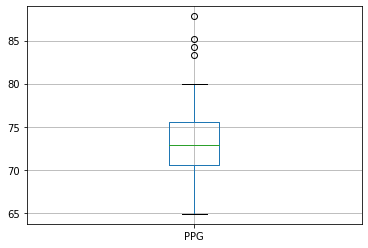

In [124]:
ppg_stats.boxplot('PPG')
# The four outliers in the boxplot are highlighted in the table below
ppg_stats.nlargest(4, 'PPG')

<AxesSubplot:title={'center':'Team Efficiency'}>

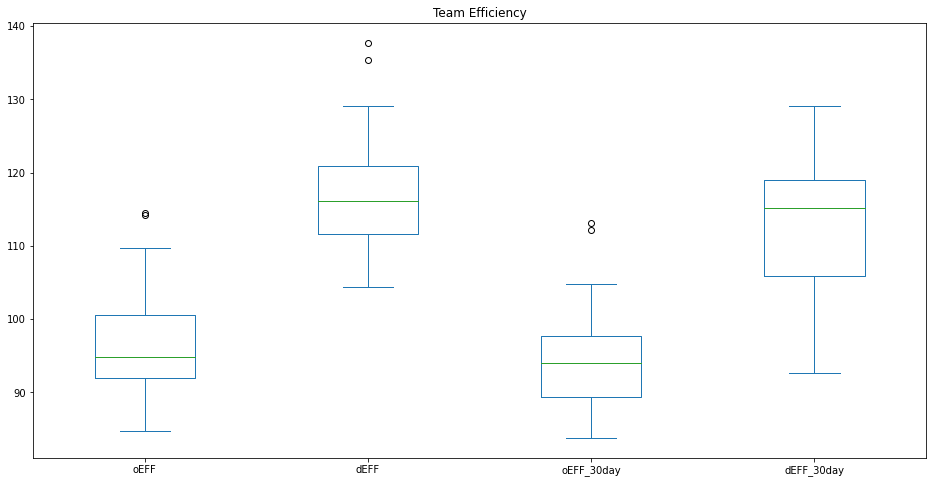

In [125]:
plt.rcParams['figure.figsize'] = [16, 8]
eff_stats[['oEFF', 'dEFF', 'oEFF_30day', 'dEFF_30day']].plot(kind='box', 
                                                             title='Team Efficiency')

In [126]:
# eff_stats.boxplot('oEFF')
# The two outliers in the offensive and deffensive boxplot 
# (they are the same two teams) are highlighted in the table below.

print('Offensive and Defensive Outliers: ')
print(eff_stats.nlargest(2, 'oEFF'))

Offensive and Defensive Outliers: 
     TeamName  TeamID  Season        oEFF        dEFF  oEFF_30day  dEFF_30day
1212  Arizona    1112    2022  114.555556  135.398693  112.153846  126.923077
1227  Gonzaga    1211    2022  114.275862  137.724138  101.750000  125.750000


In [127]:
# eff_stats.boxplot('dEFF')
# The two outliers in the boxplot are highlighted in the table below
eff_stats.nlargest(2, 'dEFF')

,TeamName,TeamID,Season,oEFF,dEFF,oEFF_30day,dEFF_30day
1227,Gonzaga,1211,2022,114.275862,137.724138,101.750000,125.750000
1212,Arizona,1112,2022,114.555556,135.398693,112.153846,126.923077


In [128]:
# eff_stats.boxplot('oEFF_30day')
# The two outliers in the boxplot are highlighted in the table below
eff_stats.nlargest(2, 'oEFF_30day')

,TeamName,TeamID,Season,oEFF,dEFF,oEFF_30day,dEFF_30day
1231,Iowa,1234,2022,109.760000,118.508571,113.153846,115.538462
1212,Arizona,1112,2022,114.555556,135.398693,112.153846,126.923077


In [129]:
# eff_stats.boxplot('dEFF_30day')

In the next plot, the two biggest outliers (Gonzaga and Arizona) are featured. I also labled Kansas (the eventual winners of the tournament).

Text(1234    102.943791
Name: oEFF, dtype: float64, 1234    119.704575
Name: dEFF, dtype: float64, 'Kansas')

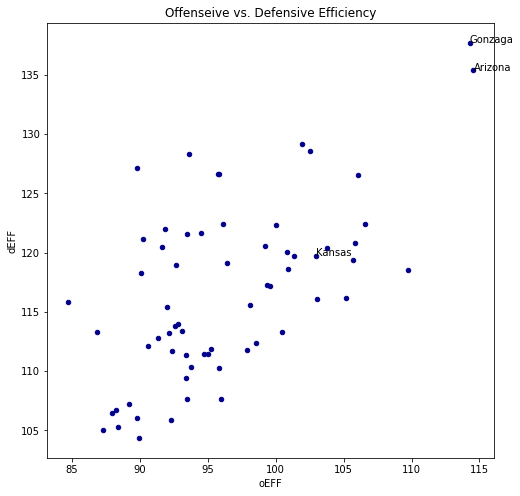

In [130]:
eff_stats.plot.scatter(x = 'oEFF', y = 'dEFF', c = 'DarkBlue', 
                       title = 'Offenseive vs. Defensive Efficiency', 
                       figsize = (8,8))


plt.text(eff_stats.oEFF[eff_stats.TeamName=='Gonzaga'], 
         eff_stats.dEFF[eff_stats.TeamName=='Gonzaga'], 
         'Gonzaga')
plt.text(eff_stats.oEFF[eff_stats.TeamName=='Arizona'], 
         eff_stats.dEFF[eff_stats.TeamName=='Arizona'], 
         'Arizona')
plt.text(eff_stats.oEFF[eff_stats.TeamName=='Kansas'], 
         eff_stats.dEFF[eff_stats.TeamName=='Kansas'], 
         'Kansas')

Text(1234    102.943791
Name: oEFF, dtype: float64, 1234    97.407407
Name: oEFF_30day, dtype: float64, 'Kansas')

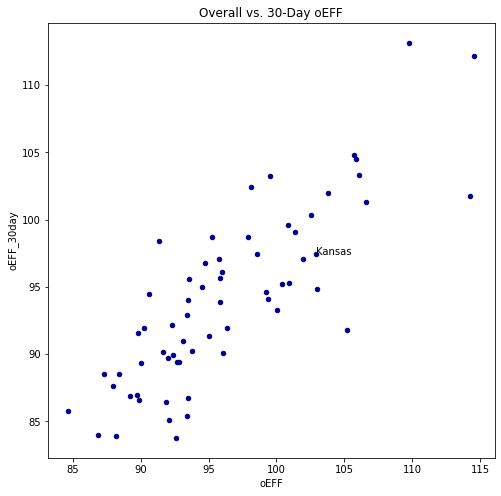

In [131]:
eff_stats.plot.scatter(x = 'oEFF', y = 'oEFF_30day', c = 'DarkBlue', 
                       title = 'Overall vs. 30-Day oEFF', 
                       figsize = (8,8))

# Eventual winner of tournament, Kansas, is highlighted
plt.text(eff_stats.oEFF[eff_stats.TeamName=='Kansas'], 
         eff_stats.oEFF_30day[eff_stats.TeamName=='Kansas'], 
         'Kansas')

Text(1234    119.704575
Name: dEFF, dtype: float64, 1234    118.62963
Name: dEFF_30day, dtype: float64, 'Kansas')

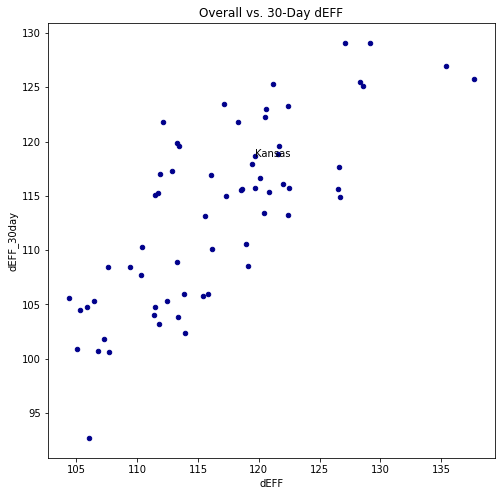

In [132]:
eff_stats.plot.scatter(x = 'dEFF', y = 'dEFF_30day', c = 'DarkBlue', 
                       title = 'Overall vs. 30-Day dEFF', 
                       figsize = (8,8))

# Eventual winner of tournament, Kansas, is highlighted
plt.text(eff_stats.dEFF[eff_stats.TeamName=='Kansas'], 
         eff_stats.dEFF_30day[eff_stats.TeamName=='Kansas'], 
         'Kansas')

Kansas, who were the eventual winners of this tournament, fall in the middle of the pack when it comes to offensive and deffensive efficiency. But they also were a one seed in the tournament, which are usually reserved for the top teams in the country. This may mean that there are other factors towards a teams success that are currently beyond the scope of this data.

During the original class project, our professor gave all of the teams wierd/unrelated names. Our group's name was "Pearl Jam vs. Ticketmaster," hence the name of the data frame used for this project. 

In [133]:
# Gathers all releavent data for teams in 2022 tournament
def prep2022(matchups,teams_df,ppg_df,eff_df,rankings_df ):
    # Pearl Jam vs Ticketmaster
    pjtm_df = pd.DataFrame()
    for i in range(0,len(matchups),2):
        matchup_df = pd.DataFrame({'Team_1': matchups[i], 'Team_2': matchups[i+1]}, index = [i])
        pjtm_df = pd.concat([pjtm_df,matchup_df], axis = 0)
    pjtm_df = pd.merge(teams_df[['TeamID','TeamName']],pjtm_df,how = 'right', left_on = ['TeamName'], right_on = ['Team_1'])
    pjtm_df = pjtm_df.rename(columns = {'TeamID': 'TeamID_1'})
    pjtm_df = pjtm_df.drop(['TeamName', 'Team_1'], axis = 1)
    pjtm_df = pd.merge(teams_df[['TeamID','TeamName']],pjtm_df ,how = 'right', left_on = ['TeamName'], right_on = ['Team_2'])
    pjtm_df = pjtm_df.drop(['TeamName', 'Team_2'], axis = 1)    
    pjtm_df = pjtm_df.rename(columns = {'TeamID': 'TeamID_2'})
    pjtm_df['Season'] = 2022
    pjtm_df['ID'] = pjtm_df['Season'].astype(str) + '_' + pjtm_df['TeamID_1'].astype(str) +'_' + pjtm_df['TeamID_1'].astype(str)
    pjtm_df = merge_features(pjtm_df, ppg_df,eff_df,rankings_df)
    return pjtm_df

In [134]:
# Runs function and drops all NAs
r64_df = prep2022(r64_matchups, teams_df, ppg_df, eff_df, rankings_df)

r64_df = r64_df.dropna()

print(r64_df)

    TeamID_2  TeamID_1  Season              ID   PPG_diff  WPerc_diff  \
0       1209      1211    2022  2022_1211_1211  20.414253    0.296552   
1       1272      1129    2022  2022_1129_1129  -8.052351    0.110459   
2       1308      1163    2022  2022_1163_1163   2.372126   -0.074353   
3       1436      1116    2022  2022_1116_1116   1.921086   -0.086174   
4       1323      1104    2022  2022_1104_1104   8.378808   -0.083669   
5       1286      1403    2022  2022_1403_1403  -3.519158   -0.045956   
6       1172      1277    2022  2022_1277_1277  -2.283292   -0.165441   
7       1168      1181    2022  2022_1181_1181  11.025017    0.168357   
8       1313      1124    2022  2022_1124_1124   3.381944    0.034722   
9       1266      1314    2022  2022_1314_1314   2.973889    0.114370   
10      1231      1388    2022  2022_1388_1388  -1.037471    0.168133   
11      1103      1417    2022  2022_1417_1417   5.993208    0.071573   
12      1439      1400    2022  2022_1400_1400  -2.

# Model: Extreme Gradient Boosting (XGB)

XGB models are enhanced versions of Gradient Boosted Decision Tree models. This means that, very basically, it runs a number of decision trees where each tree tries to correct the error of the previous tree.



In [135]:
'''
Validates the accuracy of a XGBoost model using the previous five 
seansons/torunaments as the train/test data respectively.
'''
dtest = xgb.DMatrix(X_test, y_test, feature_names=X_test.columns)
dtrain = xgb.DMatrix(X_train, y_train,feature_names=X_train.columns)

param = {'verbosity':1, 
         'objective':'binary:logistic',
         'booster':'gblinear',
         'eval_metric' :'logloss',
         'learning_rate': 0.05}

evallist = [(dtrain, 'train')] 

In [136]:
# Prints the error for each round of training
num_round = 30
bst = xgb.train(param, dtrain, num_round, evallist) 

[0]	train-logloss:0.62740
[1]	train-logloss:0.58824
[2]	train-logloss:0.56251
[3]	train-logloss:0.54483
[4]	train-logloss:0.53232
[5]	train-logloss:0.52335
[6]	train-logloss:0.51666
[7]	train-logloss:0.51166


/usr/local/lib/python3.8/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[8]	train-logloss:0.50786
[9]	train-logloss:0.50497
[10]	train-logloss:0.50269
[11]	train-logloss:0.50090
[12]	train-logloss:0.49948
[13]	train-logloss:0.49833
[14]	train-logloss:0.49741
[15]	train-logloss:0.49665
[16]	train-logloss:0.49603
[17]	train-logloss:0.49552
[18]	train-logloss:0.49510
[19]	train-logloss:0.49476
[20]	train-logloss:0.49447
[21]	train-logloss:0.49424
[22]	train-logloss:0.49404
[23]	train-logloss:0.49388
[24]	train-logloss:0.49374
[25]	train-logloss:0.49363
[26]	train-logloss:0.49354
[27]	train-logloss:0.49346
[28]	train-logloss:0.49339
[29]	train-logloss:0.49334


Using the Gradient Booding Classifier defined below

In [137]:
# Regular season statistics from 2016-2021 (Excluding 2020)
X_train = megareg_df[['PPG_diff', 'WPerc_diff', 'oEFF_diff', 'dEFF_diff', 'oEFF_30day_diff',
                       'dEFF_30day_diff','MedianRank_diff', 'MasseyRank_diff', 'MeanRank_diff']]

# Regular season results from 2016-2021 (Excluding 2020)
y_train = megareg_df[['Result']] 

# Regular season results in 2022
X_test = r64_df[['PPG_diff', 'WPerc_diff', 'oEFF_diff', 'dEFF_diff', 'oEFF_30day_diff',
                      'dEFF_30day_diff','MedianRank_diff', 'MasseyRank_diff', 'MeanRank_diff']]

# Sets parameters for Gradient Boosting Classifier                   
np.random.seed(5) 

gbc = GradientBoostingClassifier(loss='deviance', 
                             learning_rate=0.1,
                             n_estimators=100, 
                             subsample=0.5, 
                             criterion='friedman_mse',
                             min_samples_split=2, 
                             min_samples_leaf=1,
                             min_weight_fraction_leaf=0.0, 
                             max_depth=5, 
                             max_features=None, 
                             verbose=1, 
                             max_leaf_nodes=None)

start = time.time()

# Fits the model using the training data
gbc.fit(X_train, np.ravel(y_train.values))

end = time.time()
xgb_time = end-start
print('Time: ', xgb_time, 'seconds')  

print("Accuracy score (training): {0:.3f}".format(gbc.score(X_train, y_train)))

# Predicts the results for the Round of 64
y_pred = gbc.predict_proba(X_test)

      Iter       Train Loss      OOB Improve   Remaining Time 


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


         1           1.3186           0.0654           21.68s
         2           1.2666           0.0535           18.49s
         3           1.2217           0.0445           17.52s
         4           1.1834           0.0367           16.92s
         5           1.1537           0.0306           16.49s
         6           1.1235           0.0255           16.08s
         7           1.1038           0.0215           15.75s
         8           1.0831           0.0183           15.54s
         9           1.0694           0.0153           15.24s
        10           1.0569           0.0132           14.97s
        20           0.9962           0.0025           13.07s
        30           0.9676           0.0004           11.31s
        40           0.9628           0.0001            9.72s
        50           0.9568          -0.0002            8.13s
        60           0.9581          -0.0003            6.54s
        70           0.9487          -0.0002            5.18s
        

In [138]:
# Displays the Round of 64 predictions
r64_df['Prob_of_Team1_Win'] = y_pred[:,1]
r64_df[['TeamID_1', 'TeamID_2', 'Prob_of_Team1_Win']]

,TeamID_1,TeamID_2,Prob_of_Team1_Win
0,1211,1209,0.955395
1,1129,1272,0.460403
2,1163,1308,0.696658
3,1116,1436,0.650722
4,1104,1323,0.511310
5,1403,1286,0.914566
6,1277,1172,0.579311
7,1181,1168,0.942237
8,1124,1313,0.957031
9,1314,1266,0.552451


In [139]:
'''
This function takes the winners from the previous round and creates a matchup
list from the next round.
'''
def MMadness(pjtm_df, teams_df):

  x = pjtm_df.TeamID_1
  y = pjtm_df.TeamID_2
  z = pjtm_df.Prob_of_Team1_Win

  ID_list = []

  for (i, j, k) in zip(x, y, z):
    if (k > 0.5):
      ID_list.append(int(i))
    else:
      ID_list.append(int(j))


  dff = teams_df[teams_df.TeamID.isin(ID_list)]
  dff = dff.reindex(dff.TeamID.map({x: i for i, x in enumerate(ID_list)}).sort_values().index)
  matchups = dff.TeamName.tolist()

  return(matchups) 

In [140]:
# Calls the MMadness function to obtain the Round of 32 matchups
r32_matchups = MMadness(r64_df, teams_df)
print(r32_matchups)

# Repeats the code to predict the results of the Round of 32
r32_df = prep2022(r32_matchups, teams_df, ppg_df, eff_df, rankings_df)

r32_df = r32_df.dropna()

X_test = r32_df[['PPG_diff', 'WPerc_diff', 'oEFF_diff', 'dEFF_diff', 'oEFF_30day_diff',
                       'dEFF_30day_diff','MedianRank_diff', 'MasseyRank_diff', 'MeanRank_diff']]

# np.random.seed(5)                        
y_pred = gbc.predict_proba(X_test)


r32_df['Prob_of_Team1_Win'] = y_pred[:,1]
r32_df[['TeamID_1', 'TeamID_2', 'Prob_of_Team1_Win']]

['Gonzaga', 'Memphis', 'Connecticut', 'Arkansas', 'Alabama', 'Texas Tech', 'Michigan St', 'Duke', 'Baylor', 'North Carolina', "St Mary's CA", 'UCLA', 'Texas', 'Purdue', 'San Francisco', 'Kentucky', 'Arizona', 'Seton Hall', 'Houston', 'Illinois', 'Colorado St', 'Tennessee', 'Ohio St', 'Villanova', 'Kansas', 'San Diego St', 'Iowa', 'Providence', 'LSU', 'Wisconsin', 'USC', 'Auburn']


,TeamID_1,TeamID_2,Prob_of_Team1_Win
0,1211,1272,0.787727
1,1163,1116,0.508918
2,1104,1403,0.398948
3,1277,1181,0.299438
4,1124,1314,0.595727
5,1388,1417,0.469663
6,1400,1345,0.266542
7,1362,1246,0.410223
8,1112,1371,0.708002
9,1222,1228,0.570896


In [141]:
# Calls the MMadness function to obtain the Sweet 16 matchups
s16_matchups = MMadness(r32_df, teams_df)
print(s16_matchups)

# Repeats the code to predict the results of the Sweet 16
s16_df = prep2022(s16_matchups, teams_df, ppg_df, eff_df, rankings_df)

s16_df = s16_df.dropna()

X_test = s16_df[['PPG_diff', 'WPerc_diff', 'oEFF_diff', 'dEFF_diff', 'oEFF_30day_diff',
                       'dEFF_30day_diff','MedianRank_diff', 'MasseyRank_diff', 'MeanRank_diff']]
                       
y_pred = gbc.predict_proba(X_test)


s16_df['Prob_of_Team1_Win'] = y_pred[:,1]
s16_df[['TeamID_1', 'TeamID_2', 'Prob_of_Team1_Win']]

['Gonzaga', 'Connecticut', 'Texas Tech', 'Duke', 'Baylor', 'UCLA', 'Purdue', 'Kentucky', 'Arizona', 'Houston', 'Tennessee', 'Villanova', 'Kansas', 'Iowa', 'Wisconsin', 'Auburn']


,TeamID_1,TeamID_2,Prob_of_Team1_Win
0,1211,1163,0.553831
1,1403,1181,0.422615
2,1124,1417,0.494216
3,1345,1246,0.492418
4,1112,1222,0.577924
5,1397,1437,0.488563
6,1242,1234,0.585238
7,1458,1120,0.379266


In [142]:
# Calls the MMadness function to obtain the Elite 8 matchups
e8_matchups = MMadness(s16_df, teams_df)
print(e8_matchups)

# Repeats the code to predict the results of the Elite 8
e8_df = prep2022(e8_matchups, teams_df, ppg_df, eff_df, rankings_df)

e8_df = e8_df.dropna()

X_test = e8_df[['PPG_diff', 'WPerc_diff', 'oEFF_diff', 'dEFF_diff', 'oEFF_30day_diff',
                       'dEFF_30day_diff','MedianRank_diff', 'MasseyRank_diff', 'MeanRank_diff']]

y_pred = gbc.predict_proba(X_test)


e8_df['Prob_of_Team1_Win'] = y_pred[:,1]
e8_df[['TeamID_1', 'TeamID_2', 'Prob_of_Team1_Win']]

['Gonzaga', 'Duke', 'UCLA', 'Kentucky', 'Arizona', 'Villanova', 'Kansas', 'Auburn']


,TeamID_1,TeamID_2,Prob_of_Team1_Win
0,1211,1181,0.551337
1,1417,1246,0.456783
2,1112,1437,0.566179
3,1242,1120,0.491426


In [143]:
# Calls the MMadness function to obtain the Final 4 matchups
f4_matchups = MMadness(e8_df, teams_df)
print(f4_matchups)

# Repeats the code to predict the results of the Final 4
f4_df = prep2022(f4_matchups, teams_df, ppg_df, eff_df, rankings_df)

f4_df = f4_df.dropna()

X_test = f4_df[['PPG_diff', 'WPerc_diff', 'oEFF_diff', 'dEFF_diff', 'oEFF_30day_diff',
                       'dEFF_30day_diff','MedianRank_diff', 'MasseyRank_diff', 'MeanRank_diff']]

y_pred = gbc.predict_proba(X_test)

f4_df['Prob_of_Team1_Win'] = y_pred[:,1]
f4_df[['TeamID_1', 'TeamID_2', 'Prob_of_Team1_Win']]

['Gonzaga', 'Kentucky', 'Arizona', 'Auburn']


,TeamID_1,TeamID_2,Prob_of_Team1_Win
0,1211,1246,0.614309
1,1112,1120,0.532297


In [144]:
# Calls the MMadness function to obtain the Championship matchup
champ_matchups = MMadness(f4_df, teams_df)
print(champ_matchups)

# Repeats the code to predict the results of the Championship
champ_df = prep2022(champ_matchups, teams_df, ppg_df, eff_df, rankings_df)

champ_df = champ_df.dropna()

X_test = champ_df[['PPG_diff', 'WPerc_diff', 'oEFF_diff', 'dEFF_diff', 'oEFF_30day_diff',
                       'dEFF_30day_diff','MedianRank_diff', 'MasseyRank_diff', 'MeanRank_diff']]

y_pred = gbc.predict_proba(X_test)


champ_df['Prob_of_Team1_Win'] = y_pred[:,1]
champ_df[['TeamID_1', 'TeamID_2', 'Prob_of_Team1_Win']]

['Gonzaga', 'Arizona']


,TeamID_1,TeamID_2,Prob_of_Team1_Win
0,1211,1112,0.520573


In [145]:
# Calls the MMadness function to obtain the Tournament Winner
winner = MMadness(champ_df, teams_df)
print(winner)

['Gonzaga']


# Model: Convolutional Neural Network


https://medium.com/re-hoop-per-rate/new-and-improved-march-madness-neural-network-for-2020-c154aa1041b7

In [146]:
# Defines the CNN model
def MMadness_model():
  model = keras.models.Sequential()
  model.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.00001), 
                         activation='relu', input_shape=(9,)))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.00001), 
                         activation='relu'))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.00001), 
                         activation='relu'))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(32, kernel_regularizer=regularizers.l2(0.00001), 
                         activation='relu'))
  model.add(layers.Dropout(0.1))
  
  model.add(layers.Dense(2, activation='softmax'))

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3, ),
      loss='sparse_categorical_crossentropy',
      metrics=['sparse_categorical_accuracy'])
  return model

In [147]:
# Fits the CNN with a user defined batch size and number of epochs
batch_size = 1000
epochs = 50

start = time.time()  

# Fits the model
roundball = MMadness_model()
history = roundball.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                   validation_split=0.1)

end = time.time()
cnn1_time = end-start
print('Time: ', cnn1_time, 'seconds')  

Epoch 1/50
46/46 [==============================] - 3s 28ms/step - loss: 0.9019 - sparse_categorical_accuracy: 0.7023 - val_loss: 0.5234 - val_sparse_categorical_accuracy: 0.7440
Epoch 2/50
46/46 [==============================] - 1s 22ms/step - loss: 0.5290 - sparse_categorical_accuracy: 0.7449 - val_loss: 0.5400 - val_sparse_categorical_accuracy: 0.7422
Epoch 3/50
46/46 [==============================] - 1s 26ms/step - loss: 0.5158 - sparse_categorical_accuracy: 0.7545 - val_loss: 0.5418 - val_sparse_categorical_accuracy: 0.7371
Epoch 4/50
46/46 [==============================] - 2s 37ms/step - loss: 0.5095 - sparse_categorical_accuracy: 0.7564 - val_loss: 0.5379 - val_sparse_categorical_accuracy: 0.7381
Epoch 5/50
46/46 [==============================] - 1s 29ms/step - loss: 0.5076 - sparse_categorical_accuracy: 0.7559 - val_loss: 0.5203 - val_sparse_categorical_accuracy: 0.7400
Epoch 6/50
46/46 [==============================] - 1s 22ms/step - loss: 0.5050 - sparse_categorical_accu

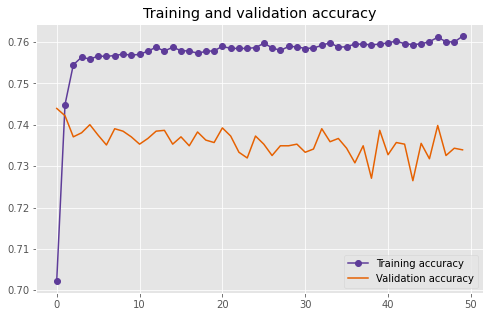

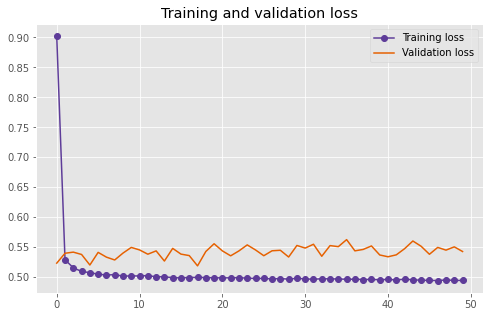

In [148]:
# Plots the accuracy and loss metrics for both the training and validation sets
def plot_train_curve(history):
    colors = ['#e66101','#fdb863','#b2abd2','#5e3c99']
    accuracy = history.history['sparse_categorical_accuracy']
    val_accuracy = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(accuracy))
    with plt.style.context("ggplot"):
        plt.figure(figsize=(8, 8/1.618))
        plt.plot(epochs, accuracy, marker='o', c=colors[3], label='Training accuracy')
        plt.plot(epochs, val_accuracy, c=colors[0], label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.figure(figsize=(8, 8/1.618))
        plt.plot(epochs, loss, marker='o', c=colors[3], label='Training loss')
        plt.plot(epochs, val_loss, c=colors[0], label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.show()
    
plot_train_curve(history)

In [149]:
# Predicts the Round of 64 results
r64_df = prep2022(r64_matchups, teams_df, ppg_df, eff_df, rankings_df)

r64_df = r64_df.dropna()

X_test = r64_df[['PPG_diff', 'WPerc_diff', 'oEFF_diff', 'dEFF_diff', 'oEFF_30day_diff',
                       'dEFF_30day_diff','MedianRank_diff', 'MasseyRank_diff', 'MeanRank_diff']]
y_pred = np.argmax(roundball.predict(X_test), axis = 1)
r64_df['Prob_of_Team1_Win'] = y_pred
r64_df[['TeamID_1', 'TeamID_2', 'Prob_of_Team1_Win']]

1/1 [==============================] - 0s 134ms/step


,TeamID_1,TeamID_2,Prob_of_Team1_Win
0,1211,1209,1
1,1129,1272,0
2,1163,1308,1
3,1116,1436,1
4,1104,1323,1
5,1403,1286,1
6,1277,1172,1
7,1181,1168,1
8,1124,1313,1
9,1314,1266,1


In [150]:
# Predicts the Round of 32 results
r32_matchups = MMadness(r64_df, teams_df)

print(r32_matchups)

r32_df = prep2022(r32_matchups, teams_df, ppg_df, eff_df, rankings_df)

r32_df = r32_df.dropna()

X_test = r32_df[['PPG_diff', 'WPerc_diff', 'oEFF_diff', 'dEFF_diff', 'oEFF_30day_diff',
                       'dEFF_30day_diff','MedianRank_diff', 'MasseyRank_diff', 'MeanRank_diff']]

y_pred = np.argmax(roundball.predict(X_test), axis = 1)
r32_df['Prob_of_Team1_Win'] = y_pred
r32_df[['TeamID_1', 'TeamID_2', 'Prob_of_Team1_Win']]




['Gonzaga', 'Memphis', 'Connecticut', 'Arkansas', 'Alabama', 'Texas Tech', 'Michigan St', 'Duke', 'Baylor', 'North Carolina', "St Mary's CA", 'UCLA', 'Texas', 'Purdue', 'San Francisco', 'Kentucky', 'Arizona', 'Seton Hall', 'Houston', 'Illinois', 'Colorado St', 'Tennessee', 'Ohio St', 'Villanova', 'Kansas', 'San Diego St', 'Iowa', 'Providence', 'LSU', 'Wisconsin', 'USC', 'Auburn']
1/1 [==============================] - 0s 110ms/step


,TeamID_1,TeamID_2,Prob_of_Team1_Win
0,1211,1272,1
1,1163,1116,1
2,1104,1403,0
3,1277,1181,0
4,1124,1314,1
5,1388,1417,0
6,1400,1345,0
7,1362,1246,0
8,1112,1371,1
9,1222,1228,1


In [151]:
# Predicts the Sweet 16 results
s16_matchups = MMadness(r32_df, teams_df)

print(s16_matchups)

s16_df = prep2022(s16_matchups, teams_df, ppg_df, eff_df, rankings_df)

s16_df = s16_df.dropna()

X_test = s16_df[['PPG_diff', 'WPerc_diff', 'oEFF_diff', 'dEFF_diff', 'oEFF_30day_diff',
                       'dEFF_30day_diff','MedianRank_diff', 'MasseyRank_diff', 'MeanRank_diff']]

y_pred = np.argmax(roundball.predict(X_test), axis = 1)
s16_df['Prob_of_Team1_Win'] = y_pred
s16_df[['TeamID_1', 'TeamID_2', 'Prob_of_Team1_Win']]

['Gonzaga', 'Connecticut', 'Texas Tech', 'Duke', 'Baylor', 'UCLA', 'Purdue', 'Kentucky', 'Arizona', 'Houston', 'Tennessee', 'Villanova', 'Kansas', 'Iowa', 'LSU', 'Auburn']
1/1 [==============================] - 0s 29ms/step


,TeamID_1,TeamID_2,Prob_of_Team1_Win
0,1211,1163,1
1,1403,1181,0
2,1124,1417,1
3,1345,1246,1
4,1112,1222,1
5,1397,1437,1
6,1242,1234,1
7,1261,1120,0


In [152]:
# Predicts the Elite 8 results
e8_matchups = MMadness(s16_df, teams_df)

print(e8_matchups)

e8_df = prep2022(e8_matchups, teams_df, ppg_df, eff_df, rankings_df)

e8_df = e8_df.dropna()

X_test = e8_df[['PPG_diff', 'WPerc_diff', 'oEFF_diff', 'dEFF_diff', 'oEFF_30day_diff',
                       'dEFF_30day_diff','MedianRank_diff', 'MasseyRank_diff', 'MeanRank_diff']]

y_pred = np.argmax(roundball.predict(X_test), axis = 1)
e8_df['Prob_of_Team1_Win'] = y_pred
e8_df[['TeamID_1', 'TeamID_2', 'Prob_of_Team1_Win']]

['Gonzaga', 'Duke', 'Baylor', 'Purdue', 'Arizona', 'Tennessee', 'Kansas', 'Auburn']
1/1 [==============================] - 0s 32ms/step


,TeamID_1,TeamID_2,Prob_of_Team1_Win
0,1211,1181,1
1,1124,1345,1
2,1112,1397,1
3,1242,1120,1


In [153]:
# Predicts the Final 4 results
f4_matchups = MMadness(e8_df, teams_df)

print(f4_matchups)

f4_df = prep2022(f4_matchups, teams_df, ppg_df, eff_df, rankings_df)

f4_df = f4_df.dropna()

X_test = f4_df[['PPG_diff', 'WPerc_diff', 'oEFF_diff', 'dEFF_diff', 'oEFF_30day_diff',
                       'dEFF_30day_diff','MedianRank_diff', 'MasseyRank_diff', 'MeanRank_diff']]

y_pred = np.argmax(roundball.predict(X_test), axis = 1)
f4_df['Prob_of_Team1_Win'] = y_pred
f4_df[['TeamID_1', 'TeamID_2', 'Prob_of_Team1_Win']]

['Gonzaga', 'Baylor', 'Arizona', 'Kansas']
1/1 [==============================] - 0s 27ms/step


,TeamID_1,TeamID_2,Prob_of_Team1_Win
0,1211,1124,1
1,1112,1242,1


In [154]:
# Predicts the Championship results
champ_matchups = MMadness(f4_df, teams_df)

print(champ_matchups)

champ_df = prep2022(champ_matchups, teams_df, ppg_df, eff_df, rankings_df)

champ_df = champ_df.dropna()

X_test = champ_df[['PPG_diff', 'WPerc_diff', 'oEFF_diff', 'dEFF_diff', 'oEFF_30day_diff',
                       'dEFF_30day_diff','MedianRank_diff', 'MasseyRank_diff', 'MeanRank_diff']]

y_pred = np.argmax(roundball.predict(X_test), axis = 1)
champ_df['Prob_of_Team1_Win'] = y_pred
champ_df[['TeamID_1', 'TeamID_2', 'Prob_of_Team1_Win']]

['Gonzaga', 'Arizona']
1/1 [==============================] - 0s 36ms/step


,TeamID_1,TeamID_2,Prob_of_Team1_Win
0,1211,1112,0


In [155]:
# Predicts the Tounrnamet Winners
winner = MMadness(champ_df, teams_df)
print(winner)

['Arizona']
